In [2]:
!git clone https://github.com/JIHOO97/X-ray-project.git

Cloning into 'X-ray-project'...
remote: Enumerating objects: 10826, done.
remote: Counting objects: 100% (4182/4182), done.
remote: Compressing objects: 100% (4182/4182), done.
remote: Total 10826 (delta 0), reused 4181 (delta 0), pack-reused 6644
Receiving objects: 100% (10826/10826), 1.86 GiB | 21.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (10833/10833), done.


## Import libraries

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import PIL

from tensorflow.keras.preprocessing import image
%matplotlib inline

## Path configuration

In [19]:
train_dir = '/opt/ml/x-ray project/X-ray-project/images/train'
test_dir = '/opt/ml/x-ray project/X-ray-project/images/test'

In [80]:
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/normal')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/pneumonia')]
tuber_imgs = [fn for fn in os.listdir(f'{train_dir}/tuberculosis')]

normal_test_imgs = [fn for fn in os.listdir(f'{test_dir}/normal')]
pneumo_test_imgs = [fn for fn in os.listdir(f'{test_dir}/pneumonia')]
tuber_test_imgs = [fn for fn in os.listdir(f'{test_dir}/tuberculosis')]

In [5]:
# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)
select_tuber = np.random.choice(tuber_imgs, 3, replace = False)

## Raw comparison

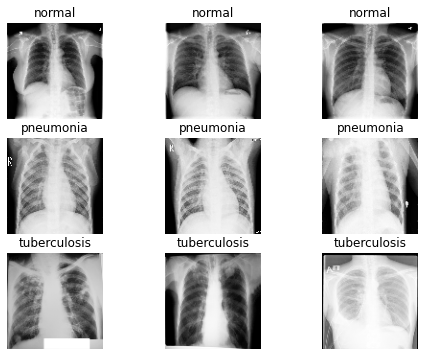

(4401, 3875, 960)

In [11]:
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(9):
    if i < 3:
        fp = f'{train_dir}/normal/{select_norm[i]}'
        label = 'normal'
    elif i >= 3 and i < 6:
        fp = f'{train_dir}/pneumonia/{select_pneu[i-3]}'
        label = 'pneumonia'
    else:
        fp = f'{train_dir}/tuberculosis/{select_tuber[i-6]}'
        label = 'tuberculosis'
    ax = fig.add_subplot(3, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(normal_imgs), len(pneumo_imgs), len(tuber_imgs)

## Image to Numpy

In [16]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(f'{train_dir}/normal/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/pneumonia/', pneumo_imgs)
tuberculosis_images = img2np(f'{train_dir}/tuberculosis/', tuber_imgs)

## Average images

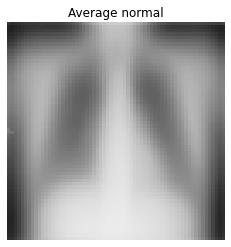

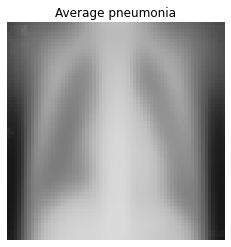

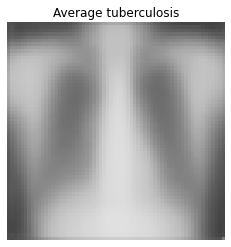

In [17]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'normal')
pneu_mean = find_mean_img(pnemonia_images, 'pneumonia')
tuber_mean = find_mean_img(tuberculosis_images, 'tuberculosis')

## Average Image Size

**Average train image size**

In [78]:
def get_mean_img_size(path, list_of_filename):
    total_width = []
    total_height = []
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        img = PIL.Image.open(fp)
        width, height = img.size
        total_width.append(width)
        total_height.append(height)
    avg_width = sum(total_width) / len(total_width)
    avg_height = sum(total_height) / len(total_height)
    return [avg_width,avg_height]
        
avg_normal_size = get_mean_img_size(f'{train_dir}/normal/', normal_imgs)
avg_pneumonia_size = get_mean_img_size(f'{train_dir}/pneumonia/', pneumo_imgs)
avg_tuberculosis_size = get_mean_img_size(f'{train_dir}/tuberculosis/', tuber_imgs)

avg_width = (avg_normal_size[0] + avg_pneumonia_size[0] + avg_tuberculosis_size[0])/3
avg_height = (avg_normal_size[1] + avg_pneumonia_size[1] + avg_tuberculosis_size[1])/3

print(avg_width, avg_height)

828.5381581657272 674.3066756825184


**Average test image size**

In [81]:
avg_test_normal_size = get_mean_img_size(f'{test_dir}/normal/', normal_test_imgs)
avg_test_pneumonia_size = get_mean_img_size(f'{test_dir}/pneumonia/', pneumo_test_imgs)
avg_test_tuberculosis_size = get_mean_img_size(f'{test_dir}/tuberculosis/', tuber_test_imgs)

avg_test_width = (avg_test_normal_size[0] + avg_test_pneumonia_size[0] + avg_test_tuberculosis_size[0])/3
avg_test_height = (avg_test_normal_size[1] + avg_test_pneumonia_size[1] + avg_test_tuberculosis_size[1])/3

print(avg_test_width, avg_test_height)

774.7868850155413 617.8058970487465


## Principal Component Analysis

Number of PC:  10


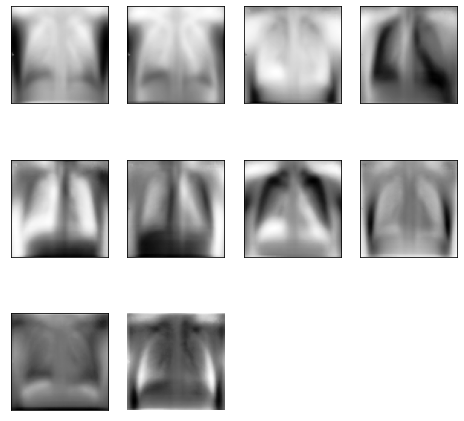

Number of PC:  14


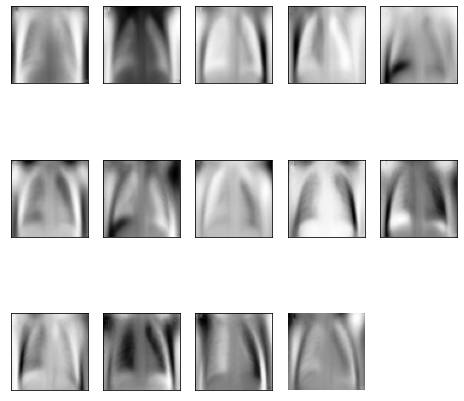

Number of PC:  12


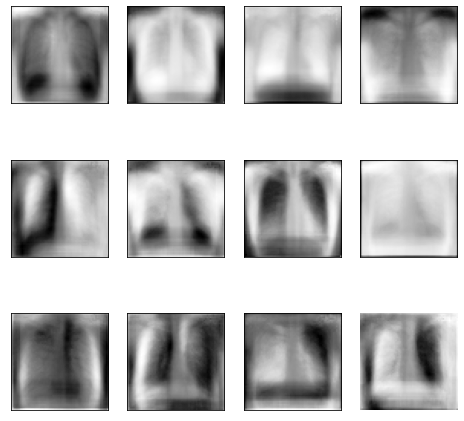

In [18]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_images, 'normal'))
plot_pca(eigenimages(pnemonia_images, 'pneumonia'))
plot_pca(eigenimages(tuberculosis_images, 'tuberculosis'))

## Data distrubution

In [58]:
normal_train_imgs = [fn for fn in os.listdir(f'{train_dir}/normal')]
pneumo_train_imgs = [fn for fn in os.listdir(f'{train_dir}/pneumonia')]
tuber_train_imgs = [fn for fn in os.listdir(f'{train_dir}/tuberculosis')]

normal_test_imgs = [fn for fn in os.listdir(f'{test_dir}/normal')]
pneumo_test_imgs = [fn for fn in os.listdir(f'{test_dir}/pneumonia')]
tuber_test_imgs = [fn for fn in os.listdir(f'{test_dir}/tuberculosis')]

**Train images distribution**

In [45]:
train_imgs = {
    "normal": len(normal_train_imgs),
    "pneumonia": len(pneumo_train_imgs),
    "tuberculosis": len(tuber_train_imgs)
}
train_keys = list(train_imgs.keys())
train_values = list(train_imgs.values())

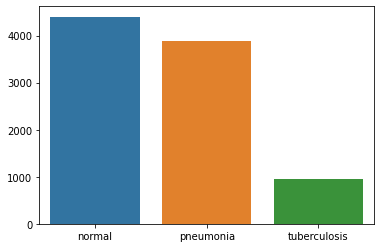

In [47]:
## barplot
sns.barplot(x=train_keys, y=train_values)
plt.show()

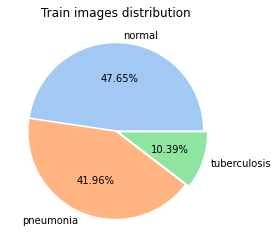

In [57]:
## pieplot
colors = sns.color_palette('pastel')[0:3]
plt.pie(train_values, labels=train_keys, colors = colors, autopct='%.2f%%', explode = (0.01, 0.01, 0.05))
plt.title("Train images distribution")
plt.show()

**Test images distrubution**

In [42]:
test_imgs = {
    "normal": len(normal_test_imgs),
    "pneumonia": len(pneumo_test_imgs),
    "tuberculosis": len(tuber_test_imgs)
}
test_keys = list(test_imgs.keys())
test_values = list(test_imgs.values())

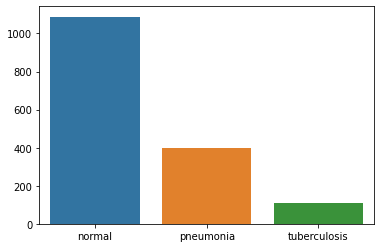

In [54]:
## barplot
sns.barplot(x=test_keys, y=test_values)
plt.show()

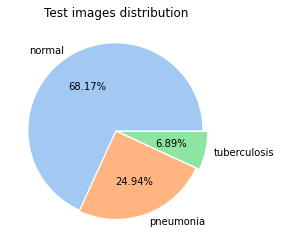

In [56]:
## pieplot
plt.pie(test_values, labels=test_keys, colors = colors, autopct='%.2f%%', explode = (0.01, 0.01, 0.05))
plt.title("Test images distribution")
plt.show()